# Credit Score Classification 

# 

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.options.mode.copy_on_write = True

## Datasets

The <a href="https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/" class="external"> dataset </a> was obtained from Kaggle after doing an extensive search for a proper dataset that will classify whether a customer can issue a credit card or not. The goals considered when looked for a dataset was that has high quality data and its has the potential to be realistic since this type of information usually is private or dummy datasets are artifficialy created.

It is obtained two different datasets in csv form. The first one is application record, where the information of applicants fill their information such as gender, has a car or property, actual work, time from birth, and other features. The credit record is the one that manages the history of actual customers with credit card and evaluates their status and time since the issue began. 

What is importante to notice is that a target label is not available, so it is necessary to search for a techique to determine whether an applicant is a good or bad client.


In [5]:
record = pd.read_csv('../data/application_record.csv')
credit = pd.read_csv('../data/credit_record.csv')

In [68]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [69]:
record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [70]:
print('Unique IDs in application record: {}'.format(len(record['ID'].unique())))
print('Unique IDs in credit record: {}'.format(len(credit['ID'].unique())))
id_shared = set(record['ID'].unique()).intersection(set(credit['ID'].unique()))
print('IDs in both records: {}'.format(len(id_shared)))

Unique IDs in application record: 438510
Unique IDs in credit record: 45985
IDs in both records: 36457


## Relevant Functions

In [71]:
def calculate_rate(df, thres, credit): 
    '''calculate bad customer rate
    '''
    tmp_df = credit[['ID']]
    tmp_df['status'] = credit['STATUS'].apply(lambda x: 1 if x >=thres else 0)
    
    sumagg = tmp_df.groupby('ID')['status'].max()
    df = pd.merge(df, sumagg, on = 'ID', how = 'left')
    rate = df['status'].fillna(0).mean()
    return round(rate, 5)

def get_div_num(df, feature):
    div_num = 1
    while (df[feature].min() % div_num) <= 0.0:
        div_num *= 10
    return div_num

def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')

In [123]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    count_df = df.groupby([feature, target]).agg('count').iloc[:,0].sort_index(ascending=[False, True])
    for val in sorted(df[feature].unique()):
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    count_df.loc[val].sum(),                                        # All
                    ])
        lst[-1].extend(count_df.loc[val].tolist())                                  # Good (think: Fraud == 0) and Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = data['Good'] / data['Good'].sum()
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    return iv, data

def get_category(df, feature, bins_num, qcut = False):
    data = df.copy()
    if qcut:
        data[feature] = pd.qcut(data[feature], q=bins_num, labels=False) # quantile cut
    else:
        data[feature] = pd.cut(data[feature], bins=bins_num, labels=False) # equal-length cut
    
    return data

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.colormaps.get_cmap("Blues")):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Vintage Analysis

After some research I have found that a vintage analysis is a popular method for managing risk highly used to measure performance of a portfolio from a loan in several periods of time. The next steps are focused on obtaining the best window and splitting of clients between good and bad references. 

In [73]:
vin_df = pd.DataFrame(credit['ID'].unique(), columns=['ID']).set_index('ID')
vin_df['start_month'] = credit.groupby('ID')['MONTHS_BALANCE'].min()
vin_df['end_month'] = credit.groupby('ID')['MONTHS_BALANCE'].max()
vin_df['window'] = vin_df['end_month'] - vin_df['start_month']
vin_df = vin_df.reset_index()

credit = pd.merge(credit,vin_df, how='left', on='ID')
credit0 = credit.copy()
credit0['STATUS'] = credit0['STATUS'].apply(lambda x: int(x) if x.isnumeric() else -1)
credit = credit[credit['window'] > 20]
credit['status'] = credit['STATUS'].apply(lambda x: (1 if int(x) >=2 else 0) if x.isnumeric() else 0)
credit['status'] = credit['status'].astype(np.int8)
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['start_month']
credit.sort_values(by = ['ID','month_on_book'], inplace = True)
credit.head()

,ID,MONTHS_BALANCE,STATUS,start_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4


In [74]:
denominator = vin_df.groupby(['start_month']).agg({'ID': ['count']})
denominator.reset_index(inplace = True)
denominator.columns = ['start_month','start_sum']

vintage = credit[['start_month','month_on_book']].groupby(['start_month','month_on_book']).count()

due_df = credit.groupby(['start_month', 'month_on_book', 'status'])['ID'].unique()
due_df = due_df.reset_index('status')
due_df = due_df[~due_df.index.duplicated(keep='last')]
due_df['ID'] = due_df[['status', 'ID']].apply(lambda x: [0] if x['status'] == 0 else x['ID'].tolist(), axis=1)

for month_indx in due_df.index.levels[0]:
    for idx, row in due_df.loc[month_indx,:].iterrows():
        if idx == 0:
            continue
        if row['ID'] == [0] and due_df.loc[month_indx,idx-1]['ID'] == [0]:
            continue
        elif due_df.loc[month_indx,idx-1]['ID'] != [0]:
            due_df.loc[month_indx,idx]['ID'] = row['ID'].extend(due_df.loc[month_indx,idx-1]['ID'])
                

due_df['due_count'] = due_df['ID'].apply(lambda x: len(set(x)-set([0])) if x != [0] else 0)
due_df = due_df[['due_count']].astype(float)
vintage = pd.merge(due_df, vintage, on=['start_month', 'month_on_book'], how='left')
vintage = vintage.reset_index()

vintage = pd.merge(vintage, denominator, on = ['start_month'], how = 'left')

vintage['sta_rate']  = vintage['due_count'] / vintage['start_sum']
vintage

,start_month,month_on_book,due_count,start_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [75]:
vintage_wide = vintage.pivot(index='start_month',
                             columns='month_on_book',
                             values='sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
start_month,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


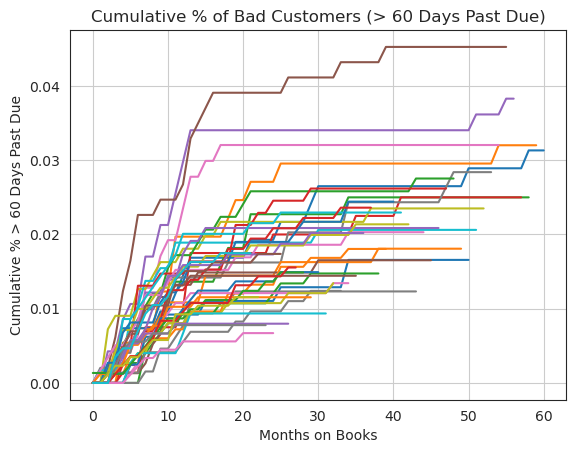

In [76]:
vintage_wide.T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

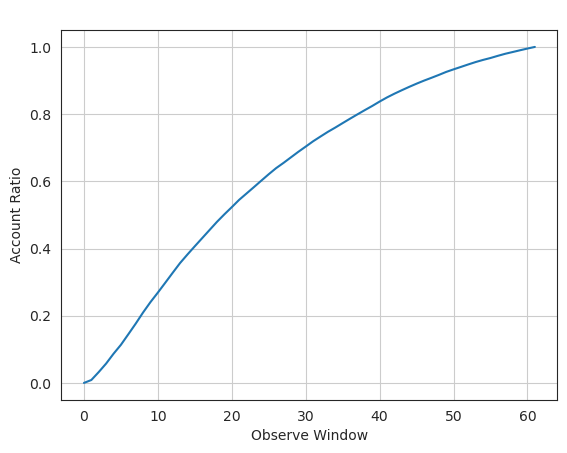

In [77]:
ratios = [0] + (vin_df['window'].value_counts().sort_index().cumsum() / len(set(vin_df['ID']))).tolist()
plt.plot(ratios)
plt.grid()
plt.title(' ')
plt.xlabel('Observe Window')
plt.ylabel('Account Ratio')
plt.show()

In [78]:
bad_ratios = [calculate_rate(vin_df, thres, credit0) for thres in range(6)]

summary_dt = pd.DataFrame({'situation':['Past due more than {} day(s)'.format(i) for i in [1,30,60,90,120,150]],
                      'bad customer ratio':bad_ratios})
summary_dt

,situation,bad customer ratio
0,Past due more than 1 day(s),0.87054
1,Past due more than 30 day(s),0.11634
2,Past due more than 60 day(s),0.01450
3,Past due more than 90 day(s),0.00720
4,Past due more than 120 day(s),0.00528
5,Past due more than 150 day(s),0.00424


With the data above is possible to determine the split for good and bad customers. As an example, using everyone with more than 1 day as past due, it would mean that 87% of customers are bad, which doesn't sound right. When searched for the vintage analysis a non-spoken rule was to have 3% of customers to be bad, since I don't have a value like that, the best possible oftion are for those over 60 days representing the 1.4%.  

## Feature Engineering

In [79]:
credit0['new_status'] = credit0['STATUS'].apply(lambda x: 1 if x >=2 else 0).astype(np.int8)
data = pd.merge(record, credit0.groupby('ID').max()[['new_status','start_month']], how='inner', on='ID')
data = data.dropna()

In [80]:
data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'# Children','AMT_INCOME_TOTAL':'Income',
                         'NAME_INCOME_TYPE':'Income Type', 'NAME_EDUCATION_TYPE':'Education Type',
                         'NAME_FAMILY_STATUS':'Marital Status', 'NAME_HOUSING_TYPE':'House Type',
                         'DAYS_BIRTH': 'Days from Birth', 'DAYS_EMPLOYED': 'Days Employed', 
                         'FLAG_MOBIL': 'Has mobile', 'FLAG_WORK_PHONE': 'Has Workphone',
                         'FLAG_PHONE': 'Has phone', 'FLAG_EMAIL':'Has email','OCCUPATION_TYPE':'Occupation',
                         'CNT_FAM_MEMBERS':'Size Family', 'new_status': 'Target'
                        },inplace=True)

### Information Value (IV) and Weight of Evidence (WoE)

This step is similar to the approach of a PCA or the feature importance that is available when training a Random Forest. Here the best option was to keep techniques of Finance and this would be Information Value per feature and its weight of evidence for the target label.

It is done by obtaining the logarithm of the ratio between good and bad distributions for WoE, then multiplying it with the difference between the same distributions for IV. 

In [81]:
ivtable=pd.DataFrame(data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Has mobile','start_month','Target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable

,variable,IV
1,Gender,None
2,Car,None
3,Reality,None
4,# Children,None
5,Income,None
6,Income Type,None
7,Education Type,None
8,Marital Status,None
9,House Type,None
10,Days from Birth,None


#### Information Value Binary Values

In [82]:
bin_vars = ['Gender', 'Car', 'Reality', 'Has phone', 'Has email', 'Has Workphone']

In [83]:
for cat in bin_vars:
    print('Information value for {} category'.format(cat))
    data[cat] = data[cat].factorize(sort=True)[0]
    print(data[cat].value_counts())
    iv, tmp_df = calc_iv(data,cat,'Target')
    ivtable.loc[ivtable['variable']==cat,'IV'] = iv
    tmp_df.head()
    print()
del tmp_df

Information value for Gender category
0    15630
1     9504
Name: Gender, dtype: int64
This variable's IV is: 0.02520350452745081

Information value for Car category
0    14618
1    10516
Name: Car, dtype: int64
This variable's IV is: 4.54248124999671e-06

Information value for Reality category
1    16461
0     8673
Name: Reality, dtype: int64
This variable's IV is: 0.02744070350168343

Information value for Has phone category
0    17775
1     7359
Name: Has phone, dtype: int64
This variable's IV is: 0.0005480495762639297

Information value for Has email category
0    22604
1     2530
Name: Has email, dtype: int64
This variable's IV is: 1.7343581493999816e-05

Information value for Has Workphone category
0    18252
1     6882
Name: Has Workphone, dtype: int64
This variable's IV is: 0.002042429795148461



#### Information Value Continuous Values

##### Transformation of data

Children

In [84]:
data.loc[data['# Children'] >= 2,'# Children'] = 2 # Here is to have 2+ children under the same category, easier to maintain an int rather than string
data['# Children'].value_counts(sort=False)

0    15908
2     3108
1     6118
Name: # Children, dtype: int64

Income

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: Income, dtype: int64

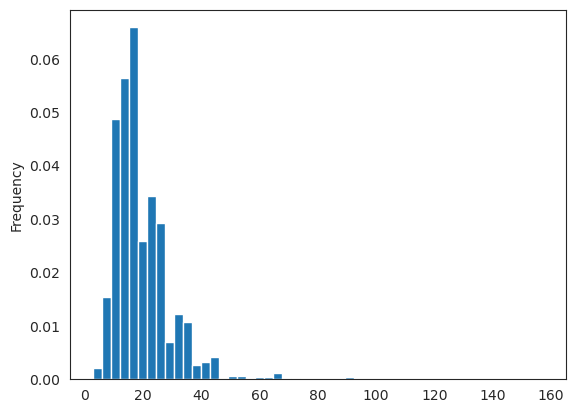

In [85]:
div_num = get_div_num(data, 'Income')
data['Income'] /= div_num
data['Income'].plot(kind='hist', bins=50, density=True)
data['Income'].value_counts(bins=10, sort=False)

In [86]:
data = get_category(data,'Income', 3, qcut=True)

Days from Birth

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64

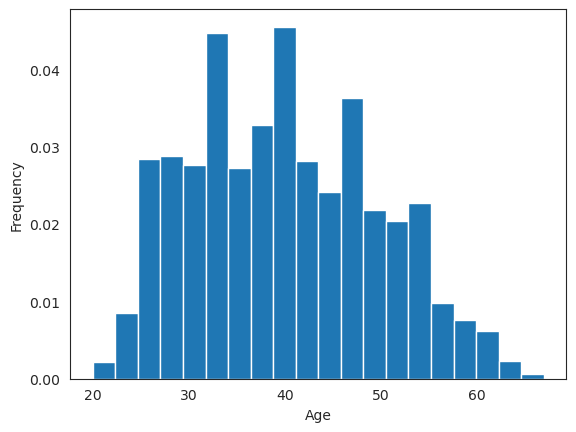

In [87]:
data['Age'] = - (data['Days from Birth']) // 365	
data['Age'].plot(kind='hist', bins=20,  density=True)
plt.xlabel('Age');
data['Age'].value_counts(bins=10, normalize=True, sort=False)

In [88]:
num_bins = np.ceil((data['Age'].max() - data['Age'].min()) / 10).astype(int)
data = get_category(data, 'Age', num_bins, qcut=False)

Days Employed

(-0.044, 4.3]    0.476566
(4.3, 8.6]       0.249702
(8.6, 12.9]      0.125567
(12.9, 17.2]     0.072850
(17.2, 21.5]     0.033938
(21.5, 25.8]     0.020888
(25.8, 30.1]     0.011459
(30.1, 34.4]     0.005451
(34.4, 38.7]     0.002308
(38.7, 43.0]     0.001273
Name: Work Time, dtype: float64

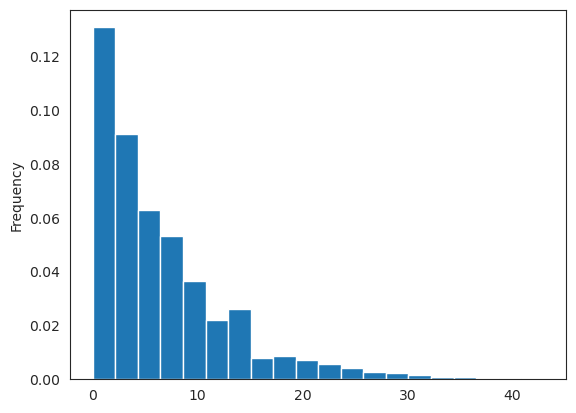

In [89]:
data['Work Time'] = - (data['Days Employed']) // 365
data['Work Time'].plot(kind='hist', bins=20, density=True)
data['Work Time'].value_counts(bins=10, normalize=True, sort=False)

In [90]:
num_bins = np.ceil((data['Work Time'].max() - data['Work Time'].min()) / 10).astype(int)
data = get_category(data, 'Work Time', num_bins, qcut=False)

Size Family

In [91]:
data['Size Family']=data['Size Family'].astype(int)
data.loc[data['Size Family'] >= 3,'Size Family'] = 3 # Here is to have 3+ family size under the same category, easier to maintain an int rather than string

data['Size Family'].value_counts(sort=False)

2    12697
1     4263
3     8174
Name: Size Family, dtype: int64

In [92]:
ivtable.loc[ivtable['variable'] == 'Days from Birth', 'variable'] = 'Age'
ivtable.loc[ivtable['variable'] == 'Days Employed', 'variable'] = 'Work Time'

In [93]:
cont_vars = ['# Children', 'Income', 'Age', 'Work Time', 'Size Family']


In [94]:
for cat in cont_vars:
    print('Information value for {} category'.format(cat))
    iv, tmp_df = calc_iv(data, cat, 'Target')
    ivtable.loc[ivtable['variable']==cat, 'IV'] = iv
    tmp_df.head()
    print()
    data = pd.get_dummies(data, columns=[cat])
del tmp_df

Information value for # Children category
This variable's IV is: 0.0011214542503301935

Information value for Income category
This variable's IV is: 0.0024219962221596752

Information value for Age category
This variable's IV is: 0.06593513858884346

Information value for Work Time category
This variable's IV is: 0.04022152230816303

Information value for Size Family category
This variable's IV is: 0.006156138510778323



#### Information Value Categorical Values

##### Transformation of data

Income Type

In [95]:
data['Income Type'].value_counts(sort=False)

Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: Income Type, dtype: int64

In [96]:
data.loc[data['Income Type']=='Pensioner','Income Type'] = 'State servant'
data.loc[data['Income Type']=='Student','Income Type'] = 'State servant'

In [97]:
data['Income Type'].value_counts(sort=False)

Working                 15622
Commercial associate     7052
State servant            2460
Name: Income Type, dtype: int64

Ocupation

In [98]:
data['Occupation'].value_counts(sort=False)

Security staff            592
Sales staff              3485
Accountants              1241
Laborers                 6211
Managers                 3012
Drivers                  2138
Core staff               3591
High skill tech staff    1383
Cleaning staff            551
Private service staff     344
Cooking staff             655
Low-skill Laborers        175
Medicine staff           1207
Secretaries               151
Waiters/barmen staff      174
HR staff                   85
Realty agents              79
IT staff                   60
Name: Occupation, dtype: int64

In [99]:
labor_occ = ['Security staff', 'Laborers', 'Drivers', 'Cleaning staff', 'Cooking staff', 'Low-skill Laborers', 'Waiters/barmen staff']
office_occ = ['Sales staff', 'Accountants', 'Core staff', 'Private service staff', 'Medicine staff', 'Secretaries', 'HR staff', 'Realty agents']
tech_occ = ['Managers', 'High skill tech staff', 'IT staff']

data['Occupation'] = data['Occupation'].apply(lambda x: 'office work' if x in office_occ else ('Labor work' if x in labor_occ else 'tech work'))
data['Occupation'].value_counts()

Labor work     10496
office work    10183
tech work       4455
Name: Occupation, dtype: int64

Education

In [100]:
data['Education Type'].value_counts()

Secondary / secondary special    16808
Higher education                  7132
Incomplete higher                  993
Lower secondary                    187
Academic degree                     14
Name: Education Type, dtype: int64

In [101]:
data.loc[data['Education Type'] == 'Academic degree','Education Type'] = 'Higher education'

In [102]:
data['Education Type'].value_counts()

Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: Education Type, dtype: int64

In [103]:
cat_vars = ['Income Type', 'Occupation', 'House Type', 'Education Type', 'Marital Status']

In [104]:
for cat in cat_vars:
    print('Information value for {} category'.format(cat))
    iv, tmp_df = calc_iv(data, cat, 'Target')
    ivtable.loc[ivtable['variable']==cat, 'IV'] = iv
    tmp_df.head()
    print()
    data = pd.get_dummies(data, columns=[cat])
del tmp_df

Information value for Income Type category
This variable's IV is: 5.159303327851404e-05

Information value for Occupation category
This variable's IV is: 0.004820472062853304

Information value for House Type category
This variable's IV is: 0.0073275026880227365

Information value for Education Type category
This variable's IV is: 0.010361794017679489

Information value for Marital Status category
This variable's IV is: 0.043137115423127946



In [105]:
ivtable = ivtable.sort_values(by='IV',ascending=False)
ivtable

,variable,IV
10,Age,0.065935
8,Marital Status,0.043137
11,Work Time,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,Education Type,0.010362
9,House Type,0.007328
17,Size Family,0.006156
16,Occupation,0.00482
5,Income,0.002422


## Training of a ML model

In [106]:
data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'Days from Birth', 'Days Employed',
       'Has mobile', 'Has Workphone', 'Has phone', 'Has email', 'Target',
       'start_month', '# Children_0', '# Children_1', '# Children_2',
       'Income_0', 'Income_1', 'Income_2', 'Age_0', 'Age_1', 'Age_2', 'Age_3',
       'Age_4', 'Work Time_0', 'Work Time_1', 'Work Time_2', 'Work Time_3',
       'Work Time_4', 'Size Family_1', 'Size Family_2', 'Size Family_3',
       'Income Type_Commercial associate', 'Income Type_State servant',
       'Income Type_Working', 'Occupation_Labor work',
       'Occupation_office work', 'Occupation_tech work',
       'House Type_Co-op apartment', 'House Type_House / apartment',
       'House Type_Municipal apartment', 'House Type_Office apartment',
       'House Type_Rented apartment', 'House Type_With parents',
       'Education Type_Higher education', 'Education Type_Incomplete higher',
       'Education Type_Lower secondary',
       'Education Type_Secondary / seconda

In [107]:
X = data[['Gender', 'Reality', 'Has Workphone', '# Children_0', '# Children_1', '# Children_2',
       'Income_0', 'Income_1', 'Income_2', 'Age_0', 'Age_1', 'Age_2', 'Age_3',
       'Age_4', 'Work Time_0', 'Work Time_1', 'Work Time_2', 'Work Time_3',
       'Work Time_4', 'Size Family_1', 'Size Family_2', 'Size Family_3',
       'Occupation_Labor work', 'Occupation_office work', 'Occupation_tech work',
       'House Type_Co-op apartment', 'House Type_House / apartment',
       'House Type_Municipal apartment', 'House Type_Office apartment',
       'House Type_Rented apartment', 'House Type_With parents',
       'Education Type_Higher education', 'Education Type_Incomplete higher',
       'Education Type_Lower secondary',
       'Education Type_Secondary / secondary special',
       'Marital Status_Civil marriage', 'Marital Status_Married',
       'Marital Status_Separated', 'Marital Status_Single / not married',
       'Marital Status_Widow']]

Y = data['Target']
Y = Y.astype('int')

Since this a case of a highly unbalanced dataset, the approach of using tools like SMOTE is necessary. It accelerates the procedure of augmenting data from the unbalanced class to enable a robust model.

In [108]:
X_balanced, Y_balanced = SMOTE().fit_resample(X,Y)
X_balanced = pd.DataFrame(X_balanced, columns = X.columns)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,Y_balanced, 
                                                    stratify=Y_balanced, test_size=0.1,
                                                    random_state = 0)



### Training different ML models

This step is to traing with different Machine Learning models with small to none paramater configuration in order to conclude the best option for proper finetuning considering the highest value of accuracy.

Accuracy Score is 0.83593
      0     1
0  2383    89
1   722  1749
[[0.96399676 0.03600324]
 [0.2921894  0.7078106 ]]


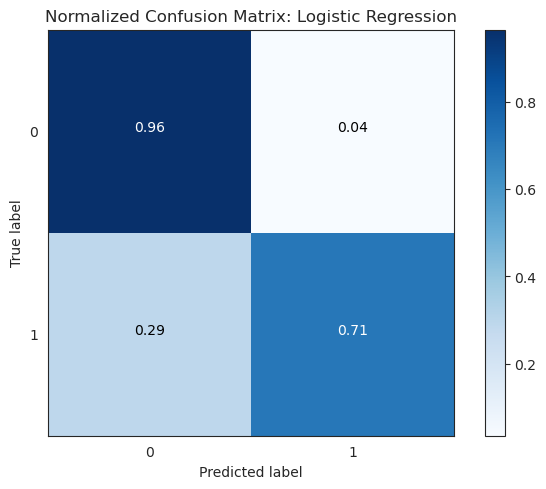

In [125]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs',
                           max_iter = 300)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))

cm = confusion_matrix(y_test,y_predict)

print(pd.DataFrame(cm))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(cm,
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

Accuracy Score is 0.82865
      0     1
0  1773   699
1   148  2323
[[0.71723301 0.28276699]
 [0.05989478 0.94010522]]


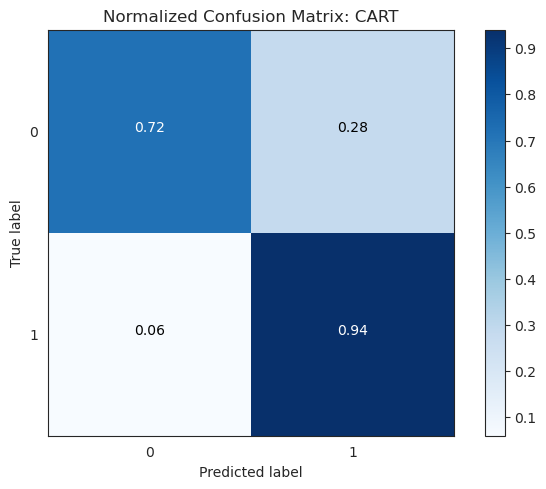

In [126]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

Accuracy Score is 0.89885
      0     1
0  2069   403
1    97  2374
[[0.83697411 0.16302589]
 [0.03925536 0.96074464]]


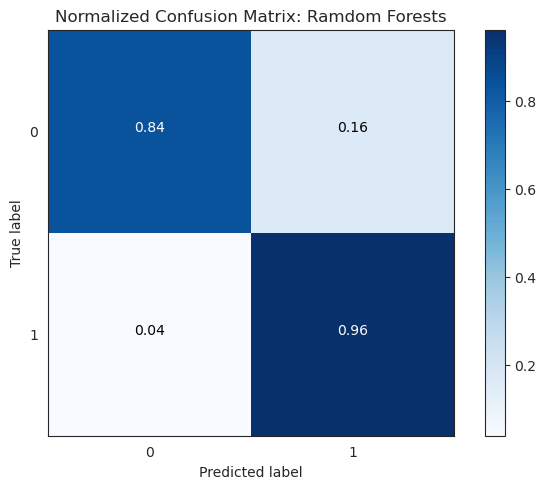

In [127]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

Accuracy Score is 0.83472
      0     1
0  2472     0
1   817  1654
[[1.         0.        ]
 [0.33063537 0.66936463]]


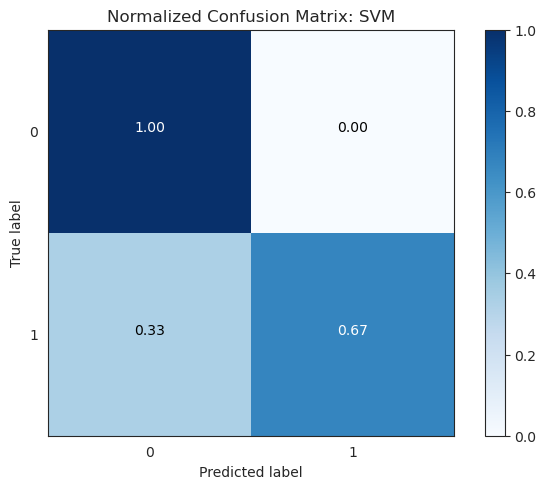

In [128]:
model = SVC(C = 0.8,
                kernel='linear')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')

In [129]:
model = LGBMClassifier(num_leaves=31,
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 22241, number of negative: 22240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 44481, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000045
[LightGBM] [Info] Start training from score 0.000045


Accuracy Score is 0.92353
      0     1
0  2264   208
1   170  2301


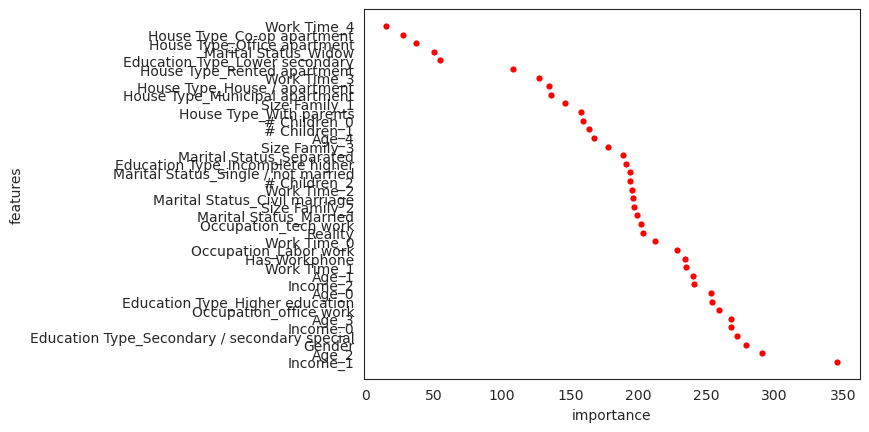

In [130]:
plot_importance(model, X_train,20)   

In [131]:
model.booster_.feature_importance(importance_type='gain')

array([30155.63389397, 43162.20212173, 31470.16507149, 23157.20029068,
       14072.80737114, 17705.02173042, 30110.45127106, 39777.25729752,
       34067.23274612, 30680.68568039, 26318.19975662, 30234.97317886,
       53388.85810852, 28213.06755638, 34155.02895546, 41669.98147583,
       26146.35512543, 18846.70513725,  1142.9309845 , 21903.07593155,
       22693.45427895, 24079.08217239, 40796.41855621, 24819.061203  ,
       25806.0331974 ,  2401.39971733, 11905.71489716, 14327.40916061,
        3818.87037659, 10451.30000496, 16935.34434319, 24560.95684052,
       21488.93740463,  2797.10380745, 26022.23883247, 22070.59114838,
       18154.87078094, 21567.59992027, 21819.01600075,  5723.0506897 ])

In [132]:
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.95347
      0     1
0  2328   144
1    86  2385


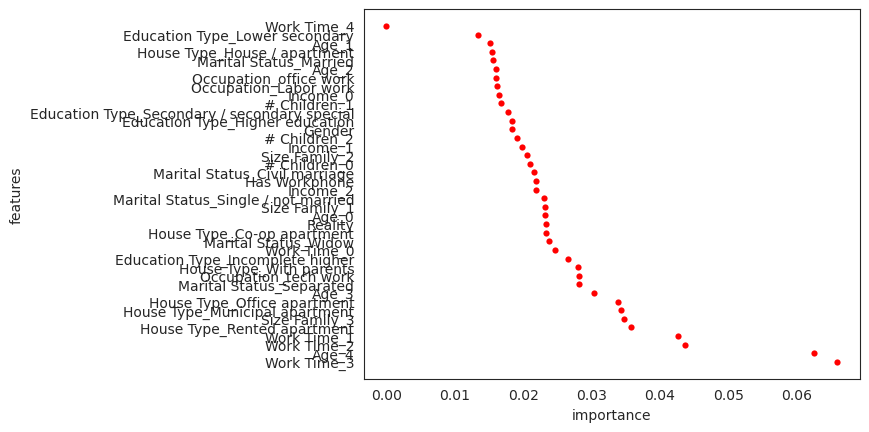

In [133]:
plot_importance(model, X_train, 20)   

### Fine-Tuning of champion model

Without analyzing to deeply the parameters, an XGB Classifier performed way better than other algorithms such as Logistic Regression or a simpler Random Forest. It will now be fine-tuned properly to have the best possible model. The approach is taking advantage of of thr GrisSearchCV class to obtain the combination of paramaters that obtain the highest scoring.

Because of the nature of the problem, a bank might prefer to reject good customers and perhaps making a human analysis of the cause if it's wrong rather than issuing a credit card to bad customers and have a high risk to defaults. In metrics, this is a recall approach to avoid False Negative cases(Bad customers predicted as good), so there is a certainty that from all the issued cases, they were to actual good customers.

In [137]:
# model = XGBClassifier(objective='binary:logistic',
#                       nthread=4,    
#                       seed=42,
#                       subsample=0.8,
#                       tree_method='gpu_hist',
#                       max_depth=9,
#                       n_estimators=330,
#                       learning_rate=0.1,
#                       min_child_weight=4)

# parameters = {
#     # 'max_depth': range (4, 14),
#     # 'n_estimators': range(90, 340, 40),
#     'learning_rate': [0.1, 0.02, 0.05],
#     'min_child_weight': range(4,12,2)
#     }

# grid_search = GridSearchCV(model,
#                            param_grid=parameters,
#                            scoring = 'recall',
#                            n_jobs = 10,
#                            verbose=True
#                            )

# grid_search.fit(X_train, y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.9768896615681157
{'learning_rate': 0.1, 'min_child_weight': 4}


In [135]:
model = XGBClassifier(objective='binary:logistic',
                      nthread=4,    
                      seed=42,
                      subsample=0.8,
                      tree_method='gpu_hist',
                      max_depth=9,
                      n_estimators=330,
                      learning_rate=0.1,
                      min_child_weight=4)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.96419
      0     1
0  2344   128
1    49  2422


[[0.94822006 0.05177994]
 [0.01983003 0.98016997]]


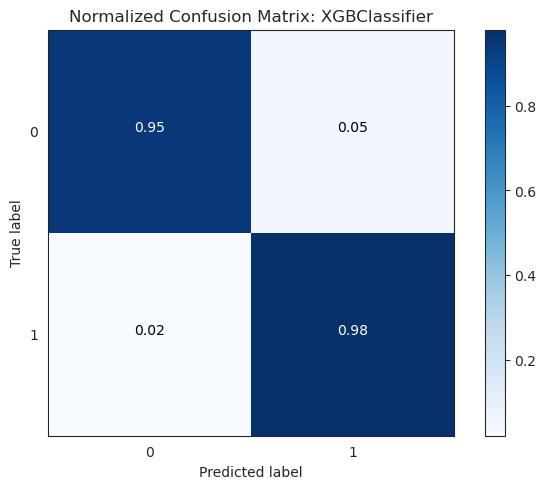

In [136]:
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: XGBClassifier')